In [1]:
# Import needed packages
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bids import BIDSLayout
import matplotlib.image as mimg
from galib import Degree

# Directories
SPINE = Path.cwd().parents[2]
DATA_DIR = SPINE / "data"
PREP_DIR = DATA_DIR / "preprocessed"
FPRP_DIR = PREP_DIR / "fmriprep"
UTL_DIR = DATA_DIR / "utils"
WMH_DIR = PREP_DIR / "WMH_segmentation"
XCP_DIR = PREP_DIR / "xcp_d"
RES_DIR = SPINE / "results"

EXT_DIR = Path("/mnt/e/petTOAD")
LQT_DIR = EXT_DIR / "results" / "LQT"
EXT_DATA_DIR = EXT_DIR / "data" / "preprocessed" / "WMH_segmentation" 

def get_sc_wmh_weighted(subj):
    spared_sc = pd.read_csv(LQT_DIR / f"sub-{subj}" / "pct_spared_sc_matrix.csv", index_col = 0)
    spared_sc_perc = spared_sc / 100
    return spared_sc_perc

def load_norm_aal_sc():
    sc_list = []
    # Loop through all files that match the pattern "S*_rawcounts.tsv"
    for filename in glob.glob(str(UTL_DIR / "AAL_not_norm" / "S*_rawcounts.csv")):
        # Load the data from the file using numpy
        arr = np.genfromtxt(filename, delimiter=",")
        # Append the loaded data to the list
        sc_list.append(arr)
    sc_mean = np.array(sc_list).mean(axis=0)
    # In the paper by Skoch et al., they state that since they "do not enforce symmetry in any direct
    # artificial way, the matrices are not perfectly symmetrical". In modeling we commonly 
    # symmetrise, so we do the same here.
    sc_mean_sym = (sc_mean + sc_mean.T) / 2
    sc_norm = sc_mean_sym / sc_mean_sym.max()
    return sc_norm

# %% ~~ Load data ~~ %%#
def get_layout_subjs():
    print("Getting the layout...")
    layout = BIDSLayout(XCP_DIR, validate=False, config=["bids", "derivatives"])
    subjs = layout.get_subjects()
    print("Done with the layout...")
    return layout, subjs


def get_wmh_load_homogeneous(subjs):
    df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv")
    df_petTOAD["PTID"] = df_petTOAD["PTID"].str.replace("_", "")
    df_petTOAD = df_petTOAD[df_petTOAD["WMH_load_subj_space"] < 80000]
    df_petTOAD = df_petTOAD[df_petTOAD["PTID"].isin(subjs)]
    df_petTOAD["WMH_load_subj_space_norm"] = (
        df_petTOAD["WMH_load_subj_space"] - df_petTOAD["WMH_load_subj_space"].min()
    ) / (
        df_petTOAD["WMH_load_subj_space"].max() - df_petTOAD["WMH_load_subj_space"].min()
    )
    homo_wmh_dict = dict(
        zip(df_petTOAD["PTID"], round(df_petTOAD["WMH_load_subj_space_norm"], 3))
    )

    return homo_wmh_dict
def get_wmh_load_homogeneous(subjs):
    df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv")
    df_petTOAD["PTID"] = df_petTOAD["PTID"].str.replace("_", "")
    df_petTOAD = df_petTOAD[df_petTOAD["WMH_load_subj_space"] < 80000]
    df_petTOAD = df_petTOAD[df_petTOAD["PTID"].isin(subjs)]
    df_petTOAD["WMH_load_subj_space_norm"] = (
        df_petTOAD["WMH_load_subj_space"] - df_petTOAD["WMH_load_subj_space"].min()
    ) / (
        df_petTOAD["WMH_load_subj_space"].max() - df_petTOAD["WMH_load_subj_space"].min()
    )
    homo_wmh_dict = dict(
        zip(df_petTOAD["PTID"], round(df_petTOAD["WMH_load_subj_space_norm"], 3))
    )

    return 

def get_classification(subjs):
    df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv")
    df_petTOAD["PTID"] = df_petTOAD["PTID"].str.replace("_", "")

    CN_no_WMH = df_petTOAD[
        (df_petTOAD["PTID"].isin(subjs))
        & ((df_petTOAD["Group_bin_Fazekas"] == "CN_no_WMH"))
    ]["PTID"].unique()

    CN_WMH = df_petTOAD[
        (df_petTOAD["PTID"].isin(subjs)) & ((df_petTOAD["Group_bin_Fazekas"] == "CN_WMH"))
    ]["PTID"].unique()

    MCI_no_WMH = df_petTOAD[
        (df_petTOAD["PTID"].isin(subjs))
        & ((df_petTOAD["Group_bin_Fazekas"] == "MCI_no_WMH"))
    ]["PTID"].unique()

    MCI_WMH = df_petTOAD[
        (df_petTOAD["PTID"].isin(subjs))
        & ((df_petTOAD["Group_bin_Fazekas"] == "MCI_WMH"))
    ]["PTID"].unique()

    CN = np.hstack([CN_WMH, CN_no_WMH])
    MCI = np.hstack([MCI_WMH, MCI_no_WMH])
    return CN, MCI, CN_no_WMH, CN_WMH, MCI_no_WMH, MCI_WMH

def get_node_spared(subj):
    wmh_df = pd.read_csv(LQT_DIR / f"sub-{subj}" / "pct_spared_sc_matrix.csv", index_col = 0)    
    wmh_spared = wmh_df[wmh_df != 0].mean(axis = 0) / 100
    # For how the code is written now, if a subject has all its connections for a specific row completely damaged,
    # the code outputs a nan. This has to be a 0, because there is no spared connection, so the damage is 100%!
    wmh_spared.iloc[:,] = np.nan_to_num(wmh_spared)
    return wmh_spared.to_numpy()

In [2]:
_, subjs = get_layout_subjs()
sc = load_norm_aal_sc()

Getting the layout...
Done with the layout...


In [3]:
import glob
dir = "/mnt/c/Users/leo_r/Downloads/092-AALV2/092-AALV2/SC"
list_a = []
for name in glob.glob(f'{dir}/*Counts.csv'): 
    a = np.genfromtxt(name, delimiter=',')
    list_a.append(a)

arr_a = np.array(list_a)


In [4]:
sc_aal2 = arr_a.mean(axis=0)
sc_aal2 = sc_aal2 / sc_aal2.max()

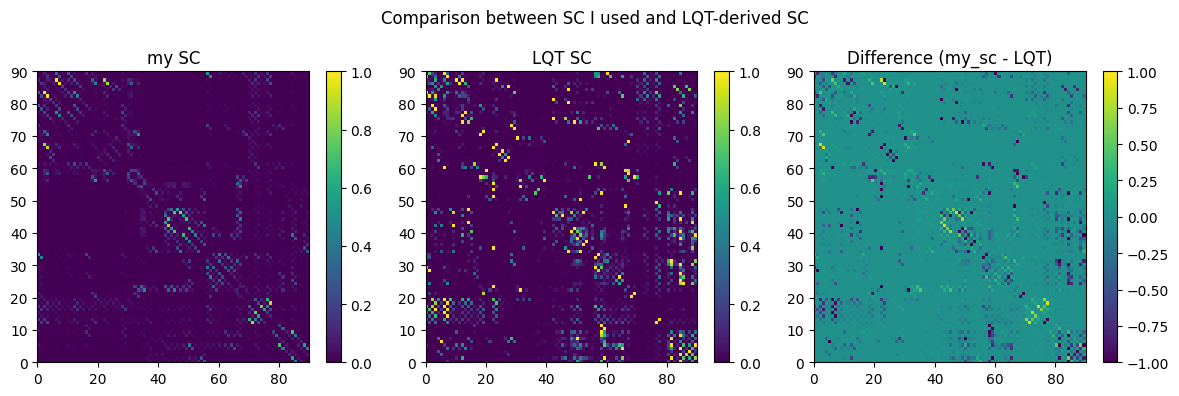

In [8]:
df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)
# Load the structural connectivity outputted by LQT
sc_lqt = pd.read_csv("/mnt/c/Users/leo_r/Desktop/connectivity.csv", index_col=0)
# Normalize by the max to be in 0-1 range
sc_lqt = sc_lqt /sc_lqt.max()

# Plot comparison between LQT SC and my_SC 
fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.pcolor(np.rot90(sc))
plt.title("my SC")
plt.colorbar()
plt.subplot(132)
plt.pcolor(np.rot90(sc_lqt))
plt.title("LQT SC")
plt.colorbar()
plt.subplot(133)
plt.pcolor(np.rot90(sc-sc_lqt), vmin=-1, vmax=1)
plt.title("Difference (my_sc - LQT)")
plt.colorbar()
fig.suptitle("Comparison between SC I used and LQT-derived SC")
fig.tight_layout()


Text(0.5, 0.98, 'Histogram of the distribution of weights among all regions')

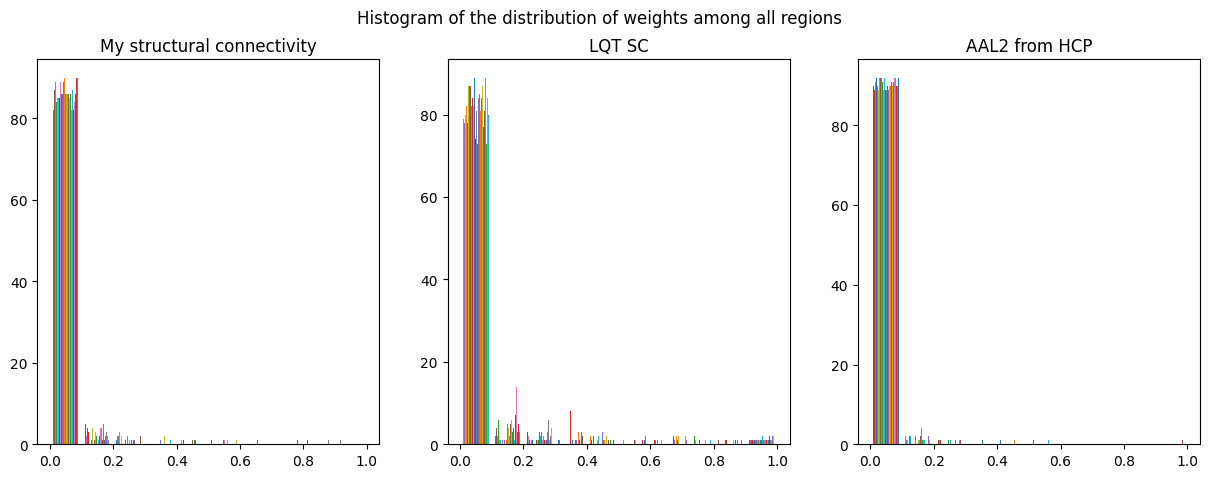

In [9]:

fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
plt.hist(sc);
plt.title("My structural connectivity")
plt.subplot(132)
plt.hist(sc_lqt);
plt.title("LQT SC")
plt.subplot(133)
plt.hist(sc_aal2);
plt.title("AAL2 from HCP")
fig.suptitle("Histogram of the distribution of weights among all regions")

LQT calculations are based on a population-averaged deterministic tractography based on the HCP-842 data by Yeh et al 2018 (from the paper: "*structural connections between a parcel pair are defined as the number of atlas streamlines that bilaterally terminate within both parcels...  HCP-842 streamline tractography atlas and the user-selected brain parcellation*").
More in detail: "*Once the atlas structural connectivity matrix has been created, the lesion is embedded into the aggregate HCP-842 streamline tractography atlas as a region-of-interest (ROI), and the atlas is filtered to retain only the subset of streamlines whose trajectories both intersect the volume occupied by the lesion (i.e., disconnected streamlines) and terminate bilaterally within a parcel pair. This results in a raw parcel-wise disconnection matrix where each entry corresponds to the number of disconnected streamlines between a parcel pair. Finally, this raw disconnection matrix is converted to a percent disconnection severity matrix relative to the atlas structural connectivity matrix. That is, the number of disconnected streamlines between each parcel pair is converted to a percentage of the total number of streamlines connecting that parcel pair in the atlas structural connectivity matrix. The values for each cell (i.e., parcel pair) in the final percent disconnection severity matrix therefore correspond to the estimated disconnection severities for each pair of parcels.*"

Text(0.5, 0.98, 'Comparison of degree across thresholds for different atlases')

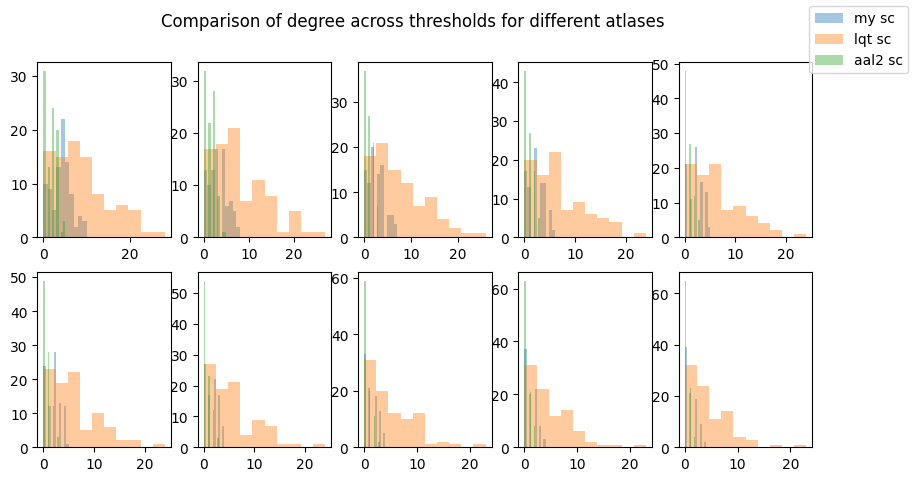

In [6]:
thresh = np.linspace(0.1, 0.3, 11)
fig, axs = plt.subplots(2, 5, figsize = (10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.hist(Degree(np.where(sc > thresh[i], 1,0)), alpha = 0.4);
    ax.hist(Degree(np.where(sc_lqt > thresh[i], 1,0)), alpha = 0.4);
    ax.hist(Degree(np.where(sc_aal2 > thresh[i], 1,0)), alpha = 0.4)

fig.legend(labels = ["my sc", "lqt sc", "aal2 sc"])
fig.suptitle("Comparison of degree across thresholds for different atlases")

The connectivity I used is similar to that of the HPC calculated by Domhof et al. so it is reasonable

In [7]:
array_subj = df_petTOAD["PTID"].to_numpy()
arr_group = df_petTOAD["Group_bin_Fazekas"].to_numpy()

# Get the disconnectivity matrices for all subjects

list_discon_sc = []
list_node_spared = []
list_perc_sc = []

for subj in array_subj:
    perc_sc = get_sc_wmh_weighted(subj=subj)
    node_spared = get_node_spared(subj)
    discon_sc = np.multiply(sc, perc_sc.values)
    list_discon_sc.append(discon_sc)
    list_node_spared.append(node_spared)
    list_perc_sc.append(perc_sc)

arr_discon_sc = np.array(list_discon_sc)
arr_node_spared = np.array(list_node_spared)
arr_perc_sc = np.array(list_perc_sc)

In [8]:
# Find the arg for each of the 4 groups
cn_no_wmh_bool = np.argwhere(arr_group == "CN_no_WMH")
cn_wmh_bool = np.argwhere(arr_group == "CN_WMH")
mci_no_wmh_bool = np.argwhere(arr_group == "MCI_no_WMH")
mci_wmh_bool = np.argwhere(arr_group == "MCI_WMH")

#These are the disconnectivity matrices for each group
arr_discon_cn_no_wmh = arr_discon_sc[cn_no_wmh_bool]
arr_discon_cn_wmh = arr_discon_sc[cn_wmh_bool]
arr_discon_mci_no_wmh = arr_discon_sc[mci_no_wmh_bool]
arr_discon_mci_wmh = arr_discon_sc[mci_wmh_bool]

#These are the spared percentages matrices for each group (1 = completely spared, 0 = completely damaged or no initial connection)
arr_perc_cn_no_wmh = arr_perc_sc[cn_no_wmh_bool]
arr_perc_cn_wmh = arr_perc_sc[cn_wmh_bool]
arr_perc_mci_no_wmh = arr_perc_sc[mci_no_wmh_bool]
arr_perc_mci_wmh = arr_perc_sc[mci_wmh_bool]

white matter load for max wmh, ADNI068S4067, is 95434.0
white matter load for min wmh, ADNI109S6364, is 11.0


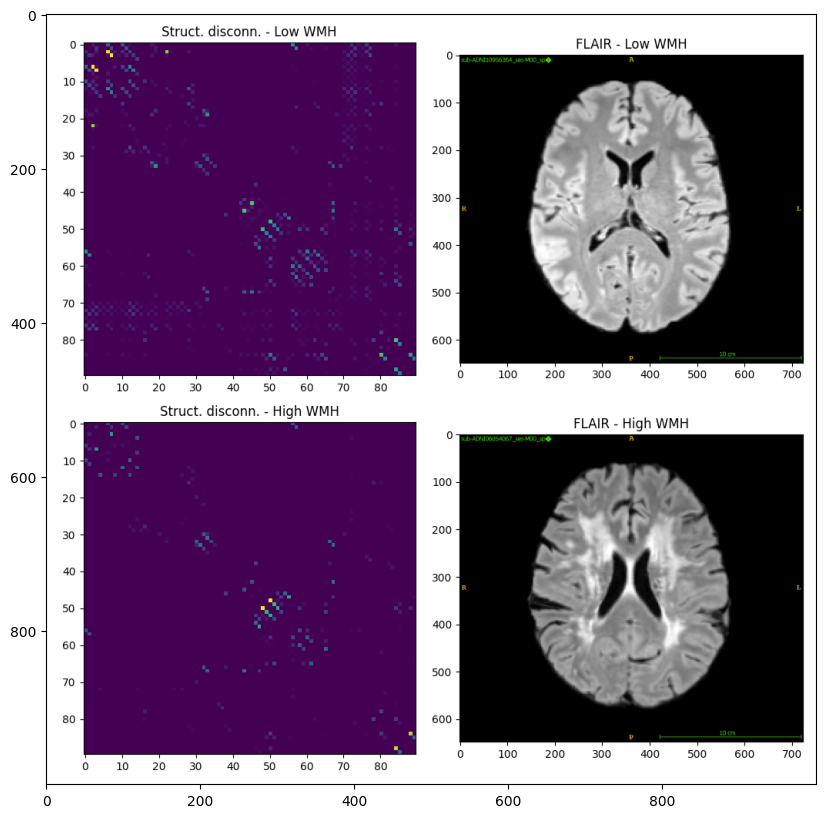

In [9]:
# Subject with highest WMH
max_wmh = df_petTOAD[df_petTOAD["WMH_load_subj_space"] == df_petTOAD["WMH_load_subj_space"].max()]["PTID"].values[0]
print(f"white matter load for max wmh, {max_wmh}, is {df_petTOAD[df_petTOAD['PTID'] == max_wmh]['WMH_load_subj_space'].values[0]}")
# Subject with lowest WMH
min_wmh = df_petTOAD[df_petTOAD["WMH_load_subj_space"] == df_petTOAD["WMH_load_subj_space"].min()]["PTID"].values[0]
print(f"white matter load for min wmh, {min_wmh}, is {df_petTOAD[df_petTOAD['PTID'] == min_wmh]['WMH_load_subj_space'].values[0]}")
# Disconnectivity for max and min WMH
arr_max = arr_discon_sc[np.argwhere(array_subj == max_wmh)].squeeze()
arr_min = arr_discon_sc[np.argwhere(array_subj == min_wmh)].squeeze()
# Spared % for max and min WMH
perc_max = arr_perc_sc[np.argwhere(array_subj == max_wmh)].squeeze()
perc_min = arr_perc_sc[np.argwhere(array_subj == min_wmh)].squeeze()

try:
    figure_comparison = mimg.imread("/mnt/c/Users/leo_r/Desktop/discon_low_vs_high_wmh.png")
    # Create a larger figure
    plt.figure(figsize=(10, 10))  # Adjust the width and height as needed
    # Display the image with a larger size
    plt.imshow(figure_comparison)
except:
    high_flair = mimg.imread("/mnt/c/Users/leo_r/Desktop/high_wmh.png")
    low_flair = mimg.imread("/mnt/c/Users/leo_r/Desktop/low_flair.png")
    fig, axs = plt.subplots(2,2, figsize = (10,10))
    axs[0,0].imshow(arr_min)
    axs[0,0].set_title("Struct. disconn. - Low WMH")
    axs[0,1].imshow(low_flair)
    axs[0,1].set_title("FLAIR - Low WMH")

    axs[1,0].imshow(arr_max)
    axs[1,0].set_title("Struct. disconn. - High WMH")
    axs[1,1].imshow(high_flair)
    axs[1,1].set_title("FLAIR - High WMH")

    fig.tight_layout()
    plt.savefig("/mnt/c/Users/leo_r/Desktop/discon_low_vs_high_wmh.png")


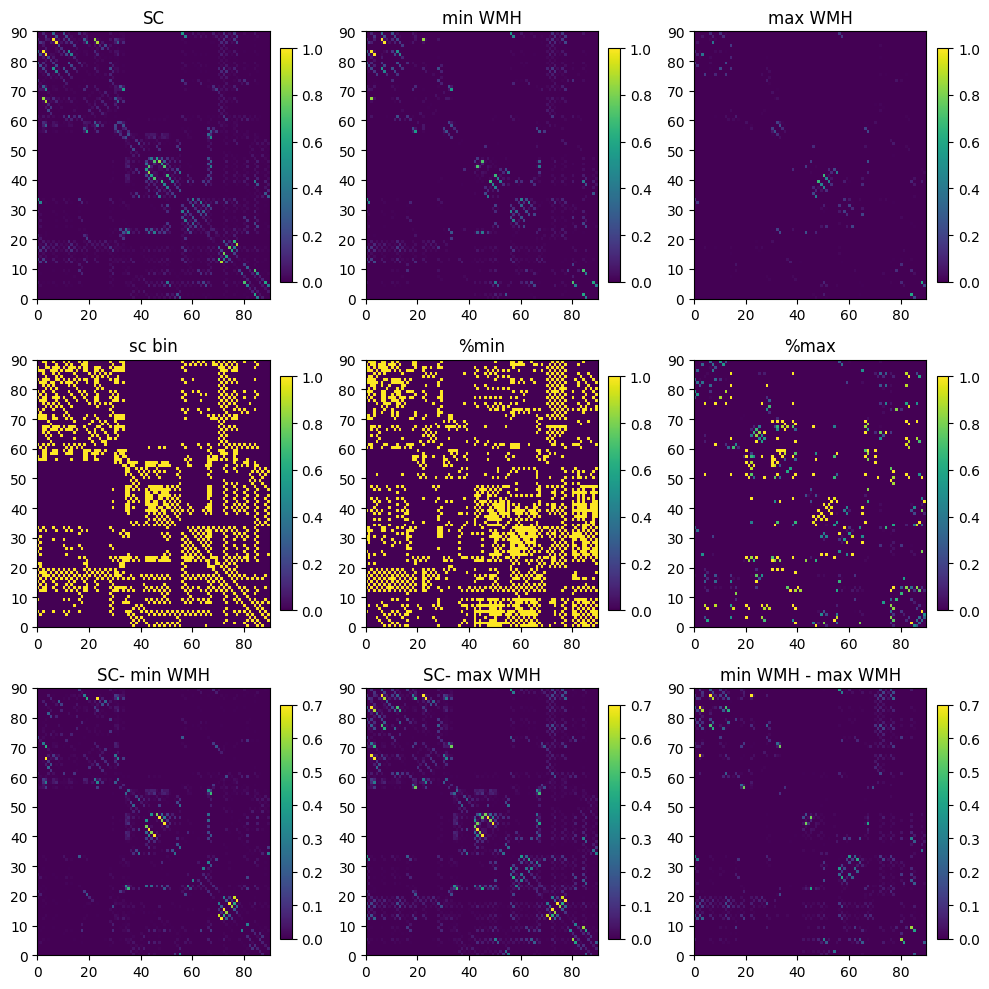

In [10]:
# Compare the normal SC with the SC of min WMH and max WMH subjs (first row)
# Compare the %spared SC with the SC of min WMH and  max WMH subjs (second row)
# Compare the difference between normal SC and the SC of min WMH, average sc and max WMH subjs and difference between min WMH and max WMH  group (third row)

fig, axs = plt.subplots(3, 3, figsize = (10, 10))
sc_bin = np.where(sc > 0.007, 1, 0)
axs_flat = axs.flatten()

list_plot = [sc, arr_min, arr_max, sc_bin, perc_min, perc_max, np.abs(arr_min - sc), np.abs(arr_max - sc), np.abs(arr_max - arr_min)]
list_title = ["SC", "min WMH", "max WMH", "sc bin", "%min", "%max", "SC- min WMH", "SC- max WMH", "min WMH - max WMH"]
for i, ax in enumerate(axs_flat):
    if i < 6:
        im = ax.pcolor(np.rot90(list_plot[i]), vmin = 0, vmax = 1)
    else:
        im = ax.pcolor(np.rot90(list_plot[i]), vmin = 0, vmax = 0.7)
    ax.set_title(list_title[i])
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()

plt.show()

Text(0.5, 0.98, 'Histogram of the distribution of weights among all regions')

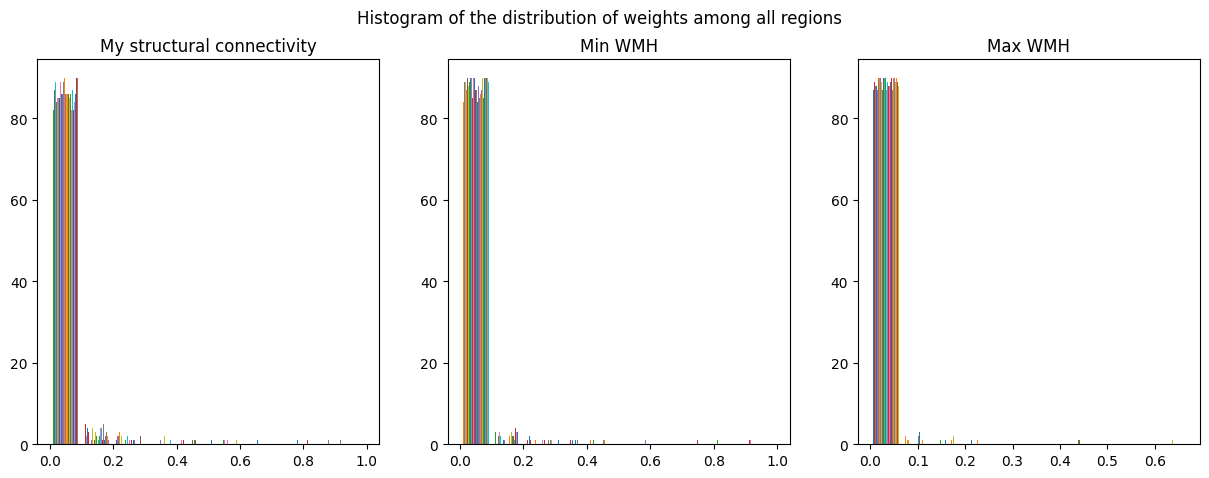

In [11]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
plt.hist(sc);
plt.title("My structural connectivity")
plt.subplot(132)
plt.hist(arr_min);
plt.title("Min WMH")
plt.subplot(133)
plt.hist(arr_max);
plt.title("Max WMH")
fig.suptitle("Histogram of the distribution of weights among all regions")

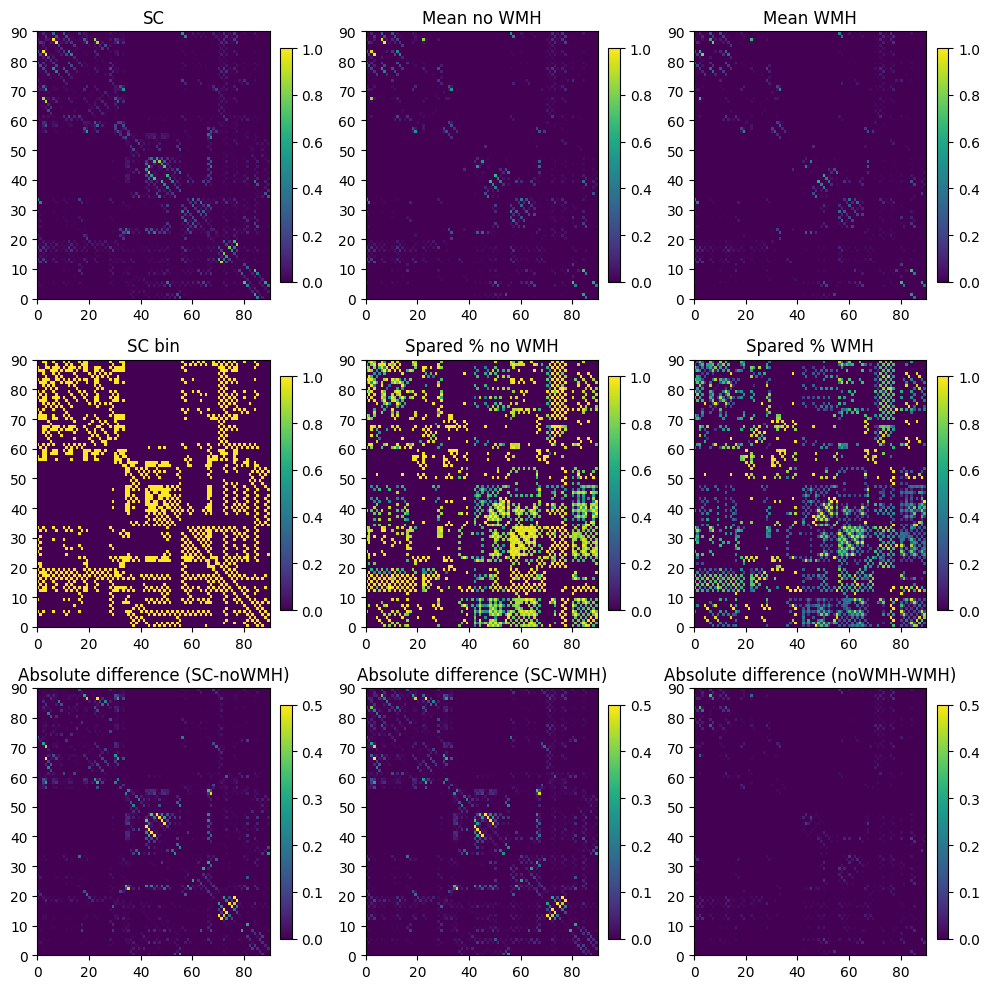

In [12]:
# Compare the normal SC with the average SC of people in the no WMH and WMH groups (independent of cognitive status) (first row)
# Compare the %spared SC with the average SC of people in the no WMH and WMH groups (independent of cognitive status) (second row)
# Compare the difference between normal SC and the average SC of people in the no WMH, average sc and average of WMH group and difference between average no WMH and average WMH  group (third row)

arr_discon_no_wmh = np.concatenate([arr_discon_cn_no_wmh, arr_discon_mci_no_wmh]).squeeze()
arr_discon_wmh = np.concatenate([arr_discon_cn_wmh, arr_discon_mci_wmh]).squeeze()

arr_perc_discon_no_wmh = np.concatenate([arr_perc_cn_no_wmh, arr_perc_mci_no_wmh]).squeeze()
arr_perc_discon_wmh = np.concatenate([arr_perc_cn_wmh, arr_perc_mci_wmh]).squeeze()

arr_mean_no_wmh = arr_discon_no_wmh.mean(axis=0)
arr_mean_wmh = arr_discon_wmh.mean(axis=0)

arr_perc_no_wmh = arr_perc_discon_no_wmh.mean(axis=0)
arr_perc_wmh = arr_perc_discon_wmh.mean(axis=0)

fig, axs = plt.subplots(3, 3, figsize = (10,10))
axs_flat = axs.flatten()
list_plot = [sc, arr_mean_no_wmh, arr_mean_wmh, sc_bin, arr_perc_no_wmh, arr_perc_wmh, np.abs(arr_mean_no_wmh - sc), np.abs(arr_mean_wmh - sc), np.abs(arr_mean_wmh - arr_mean_no_wmh)]
list_title = ["SC", "Mean no WMH", "Mean WMH", "SC bin", "Spared % no WMH", "Spared % WMH", "Absolute difference (SC-noWMH)", "Absolute difference (SC-WMH)", "Absolute difference (noWMH-WMH)"]
for i, ax in enumerate(axs_flat):
    if i < 6:
        im = ax.pcolor(np.rot90(list_plot[i]), vmin = 0, vmax = 1)
    else:
        im = ax.pcolor(np.rot90(list_plot[i]), vmin = 0, vmax = 0.5)
    ax.set_title(list_title[i])
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()

plt.show()

Text(0.5, 0.98, 'Histogram of the distribution of weights among all regions')

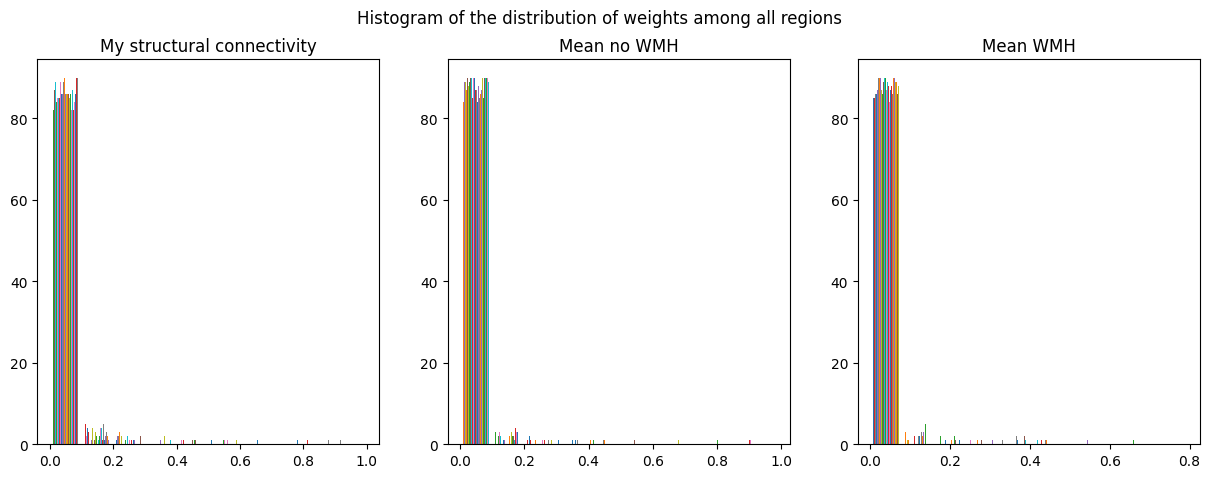

In [13]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
plt.hist(sc);
plt.title("My structural connectivity")
plt.subplot(132)
plt.hist(arr_mean_no_wmh);
plt.title("Mean no WMH")
plt.subplot(133)
plt.hist(arr_mean_wmh);
plt.title("Mean WMH")
fig.suptitle("Histogram of the distribution of weights among all regions")

In [14]:
import nibabel as nib
list_images = []
for subj in df_petTOAD["PTID"]:
    filename = EXT_DIR / "data" / "preprocessed" / "WMH_lesion_masks" / f"sub-{subj}_ses-M00_space-MNI152NLin6Asym_desc-fromSubjSpace.nii.gz"
    img = nib.load(filename)
    list_images.append(img)

arr_images = np.array(list_images)
arr_im_cn_no_wmh = arr_images[cn_no_wmh_bool]
arr_im_cn_wmh = arr_images[cn_wmh_bool]
arr_im_mci_no_wmh = arr_images[mci_no_wmh_bool]
arr_im_mci_wmh = arr_images[mci_wmh_bool]

In [15]:
from nilearn import image as nimg
from nilearn import plotting as niplot

def create_mean_wmh_map(array_wmh, group_name):
    list_arr_im = []
    for im in array_wmh:
        arr_im = im[0].get_fdata()
        list_arr_im.append(arr_im)

    group_average_map = np.sum(list_arr_im, axis=0) / len(list_arr_im)
    new_mask = nimg.new_img_like(arr_im_cn_no_wmh[0][0], group_average_map)
    nib.save(new_mask, f"/mnt/c/Users/leo_r/Desktop/{group_name}.nii.gz")
    return new_mask


In [21]:
# create_mean_wmh_map(arr_im_cn_no_wmh, "cn_no_wmh")
# create_mean_wmh_map(arr_im_cn_wmh, "cn_wmh")
# create_mean_wmh_map(arr_im_mci_no_wmh, "mci_no_wmh")
# create_mean_wmh_map(arr_im_mci_wmh, "mci_wmh")

array([0.        , 0.02702703, 0.05405405, 0.08108108, 0.10810811,
       0.13513514, 0.16216216, 0.18918919, 0.21621622, 0.24324324,
       0.27027027, 0.2972973 , 0.32432432, 0.35135135, 0.37837838,
       0.40540541, 0.43243243, 0.45945946, 0.48648649, 0.51351351,
       0.54054054, 0.56756757, 0.59459459, 0.62162162, 0.64864865,
       0.67567568, 0.7027027 , 0.72972973, 0.75675676, 0.78378378,
       0.81081081, 0.83783784, 0.86486486, 0.89189189])

In [12]:
df_petTOAD["Group_bin"] = np.where(df_petTOAD["Group_bin_Fazekas"].str.contains("no"), "no_WMH", "WMH")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

no_WMH vs. WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.362e-25 U_stat=5.065e+02


(<Axes: xlabel='Group_bin', ylabel='WMH_load_subj_space'>,
 [<statannotations.Annotation.Annotation at 0x7f8b5c00ed50>])

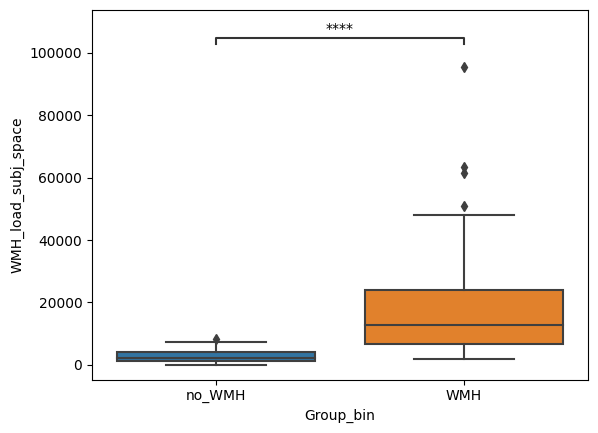

In [13]:
import seaborn as sns
from statannotations.Annotator import Annotator
pairs = [("no_WMH", "WMH")]
order = ["no_WMH", "WMH"]
f = sns.boxplot(data= df_petTOAD, x = "Group_bin", y = "WMH_load_subj_space", order = order)
annotator = Annotator(f, pairs, data=df_petTOAD, x="Group_bin", y="WMH_load_subj_space", order=order)
# Choose the type of statistical test to perform
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=1)
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CN vs. MCI: Mann-Whitney-Wilcoxon test two-sided, P_val:6.294e-01 U_stat=3.906e+03


(<Axes: xlabel='Group', ylabel='WMH_load_subj_space'>,
 [<statannotations.Annotation.Annotation at 0x7f484130d710>])

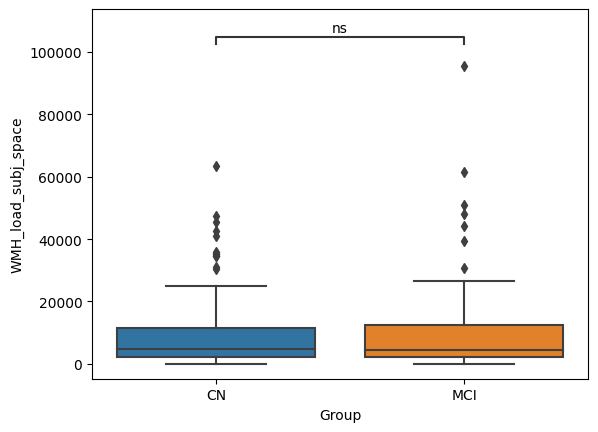

In [75]:
pairs = [("CN", "MCI")]
order = ["CN", "MCI"]
f = sns.boxplot(data= df_petTOAD, x = "Group", y = "WMH_load_subj_space", order = order)
annotator = Annotator(f, pairs, data=df_petTOAD, x="Group", y="WMH_load_subj_space", order=order)
# Choose the type of statistical test to perform
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=1)
annotator.apply_and_annotate()

In [100]:
# As an alternative we could use the median WMH in the HC group?
median_cn = np.quantile(df_petTOAD[df_petTOAD["Group"] == "MCI"]["WMH_load_subj_space"], 0.5)
df_petTOAD["median_bin"] = np.where(df_petTOAD["WMH_load_subj_space"] < median_cn, "no WMH", "WMH")
pd.crosstab(df_petTOAD["median_bin"], df_petTOAD["Fazekas_total"], normalize=True)

Fazekas_total,0.0,1.0,2.0,3.0,4.0,5.0,6.0
median_bin,,,,,,,
WMH,0.000000,0.000000,0.106383,0.117021,0.095745,0.079787,0.117021
no WMH,0.053191,0.106383,0.265957,0.058511,0.000000,0.000000,0.000000


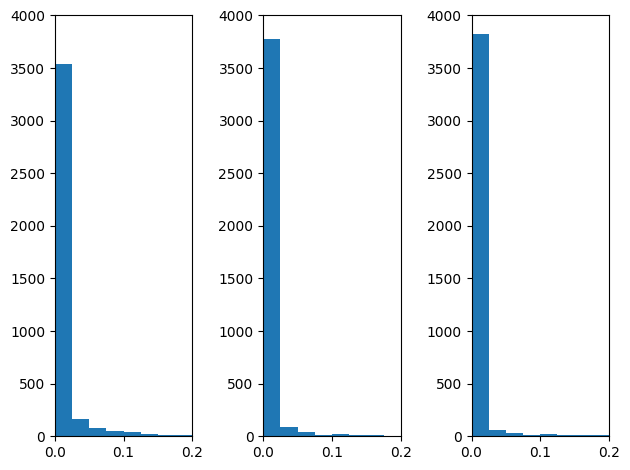

In [17]:
def get_upper_triu(mtx):
    # Get the upper triangular part of the matrix
    mtx = mtx[np.triu_indices(mtx.shape[0], k = 1)]
    # Flatten the upper triangular part to a 1D array
    
    return mtx

bin_edges = np.linspace(sc.min(), sc.max(), 40 + 1)
sc_triu = get_upper_triu(sc)
low_wmh_triu = get_upper_triu(arr_mean_no_wmh)
high_wmh_triu = get_upper_triu(arr_mean_wmh)
plt.subplot(131)
plt.hist(sc_triu, bins = bin_edges);
plt.ylim(0, 4000)
plt.xlim(0, 0.2)
plt.subplot(132)
plt.hist(low_wmh_triu, bins = bin_edges);
plt.ylim(0, 4000)
plt.xlim(0, 0.2)
plt.subplot(133)
plt.hist(high_wmh_triu, bins = bin_edges);
plt.ylim(0, 4000)
plt.xlim(0, 0.2)
plt.tight_layout()